# Implementing Logistic Regression from scratch

In [1]:
# Mounting Google Drive in Colab
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# Import statements
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score

In [3]:
# Loading the dataset
dataset_path = '/content/drive/My Drive/datasets-assignment1/Heart Disease.csv'

# In case of running the code locally
# df = pd.read_csv('Heart Disease.csv')

df = pd.read_csv(dataset_path)

In [4]:
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,HeartDisease
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [5]:
df.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,HeartDisease
count,4238.000000,4238.000000,4133.000000,4238.000000,4209.000000,4185.000000,4238.000000,4238.000000,4238.000000,4188.000000,4238.000000,4238.000000,4219.000000,4237.000000,3850.000000,4238.000000
mean,0.429212,49.584946,1.978950,0.494101,9.003089,0.029630,0.005899,0.310524,0.025720,236.721585,132.352407,82.893464,25.802008,75.878924,81.966753,0.151958
std,0.495022,8.572160,1.019791,0.500024,11.920094,0.169584,0.076587,0.462763,0.158316,44.590334,22.038097,11.910850,4.080111,12.026596,23.959998,0.359023
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,144.000000,89.875000,28.040000,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


In [6]:
df.shape

(4238, 16)

In [7]:
# Correlation matrix to find correlation between different features with HeartDisease
correlation_matrix = df.corr()
print(correlation_matrix['HeartDisease'].sort_values(ascending=False))

HeartDisease       1.000000
age                0.225256
sysBP              0.216429
prevalentHyp       0.177603
diaBP              0.145299
glucose            0.125544
diabetes           0.097317
male               0.088428
BPMeds             0.087489
totChol            0.082184
BMI                0.075192
prevalentStroke    0.061810
cigsPerDay         0.057884
heartRate          0.022913
currentSmoker      0.019456
education         -0.054059
Name: HeartDisease, dtype: float64


In [8]:
# Counting NA values in all the features
na_counts = df.isna().sum()
print(na_counts)

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
HeartDisease         0
dtype: int64


In [9]:
# The feature "education" has 105 NULL values. We replace it with "mode" as the only values possible are 1, 2, 3, 4, indicating a categorical variable
df['education'].fillna(df['education'].mode()[0], inplace=True)

In [10]:
# cigsPerDay has 29 NULL values. We replace it with median to make it robust to outliers
df['cigsPerDay'].fillna(df['cigsPerDay'].median(), inplace=True)
# We replace currentSmoker with Mode as it is categorical
df['currentSmoker'].fillna(df['currentSmoker'].mode()[0], inplace=True)

In [11]:
# We replace 'heartRate' with median to make it robust to outliers
df['heartRate'].fillna(df['heartRate'].median(), inplace=True)

In [12]:
# Since "BPMeds", "totChol", "BMI" and "glucose" have significant positive correlation value, we replace them with the median of the columns, assuming
# such data is generally skewed and median is robust to outliers

columns_to_impute = ['BPMeds', 'totChol', 'BMI', 'glucose']

# Calculate the median for each column
medians = df[columns_to_impute].median()

# Replace missing values with the median
df[columns_to_impute] = df[columns_to_impute].fillna(medians)

In [13]:
# Verification for NULL values
df.isna().sum()

,0
male,0
age,0
education,0
currentSmoker,0
cigsPerDay,0
BPMeds,0
prevalentStroke,0
prevalentHyp,0
diabetes,0
totChol,0


In [14]:
# Checking for duplicate values
duplicates = df[df.duplicated()]

print(f"Number of duplicate rows: {duplicates.shape[0]}")

Number of duplicate rows: 0


We have successfully removed all NULL values from our dataset.

In [15]:
# Saving the updated dataset as a .csv file in the same folder
output_file_path = './drive/My Drive/datasets-assignment1/Updated Heart Disease.csv'

# Save the DataFrame to a CSV file
df.to_csv(output_file_path, index=False)

print(f"Dataset saved as {output_file_path}")

Dataset saved as ./drive/My Drive/datasets-assignment1/Updated Heart Disease.csv


In [16]:
# Loading the updated dataset
dataset_path = '/content/drive/My Drive/datasets-assignment1/Updated Heart Disease.csv'
data = pd.read_csv(dataset_path)

In [17]:
data.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,HeartDisease
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [18]:
data.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,HeartDisease
count,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000
mean,0.429212,49.584946,1.954696,0.494101,8.941482,0.029259,0.005899,0.310524,0.025720,236.689476,132.352407,82.893464,25.800205,75.878716,81.603587,0.151958
std,0.495022,8.572160,1.018510,0.500024,11.902399,0.168552,0.076587,0.462763,0.158316,44.327427,22.038097,11.910850,4.071041,12.025185,22.865246,0.359023
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.080000,68.000000,72.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,262.000000,144.000000,89.875000,28.037500,83.000000,85.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


In [19]:
data.shape

(4238, 16)

In [20]:
X = data.drop('HeartDisease', axis=1)
y = data['HeartDisease']

In [21]:
# Scratch implementation for train_test_split() but leads to overfitting on the data

# def split_dataset(X, y, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_seed=42):
#     np.random.seed(random_seed)

#     indices = np.arange(X.shape[0])
#     np.random.shuffle(indices)

#     train_size = int(train_ratio * len(indices))
#     val_size = round(val_ratio * len(indices))
#     test_size = len(indices) - train_size - val_size

#     train_indices = indices[:train_size]
#     val_indices = indices[train_size:train_size + val_size]
#     test_indices = indices[train_size + val_size:]

#     X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
#     X_val, y_val = X.iloc[val_indices], y.iloc[val_indices]
#     X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]

#     return X_train, X_val, X_test, y_train, y_val, y_test

In [22]:
# Splitting the dataset into 70:15:15 (train: test: validation)
# First split : 70% into training and 30% into validation
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Second split: 50% of temp data for test, 50% for validation (15% of total data each)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Verify the sizes of each set
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Training set size: 2966
Testing set size: 636
Validation set size: 636


Till this step, we have finished analyzing our data and pre-processed our data to drop NA values and duplicate values. Further, we split our data into training, testing and validation dataset.

#### a. Implement Logistic Regression using Batch Gradient Descent. Plot training loss vs. iteration, validation loss vs. iteration, training accuracy vs iteration, and validation accuracy vs. iteration. Comment on the convergence of the model. Compare and analyze the plots.

**Reference:**


-   [Medium](https://medium.com/@koushikkushal95/logistic-regression-from-scratch-dfb8527a4226)
-   [IBM Developer](https://developer.ibm.com/articles/implementing-logistic-regression-from-scratch-in-python/)



In [23]:
class BatchGradient_lr:
    def __init__(self, learning_rate=0.001, epochs=1000):
        self.lr = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    # Sigmoid method
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    # Compute cross-entropy loss
    def compute_loss(self, y_true, y_pred):
        epsilon = 1e-9  # to avoid log(0)
        y1 = y_true * np.log(y_pred + epsilon)
        y2 = (1 - y_true) * np.log(1 - y_pred + epsilon)
        return -np.mean(y1 + y2)

    # Compute accuracy
    def compute_accuracy(self, y_true, y_pred):
        y_pred_cls = [1 if i > 0.5 else 0 for i in y_pred]
        accuracy = np.mean(y_pred_cls == y_true)
        return accuracy

    # Forward propagation
    def feed_forward(self, X):
        # y = wx + b
        z = np.dot(X, self.weights) + self.bias
        A = self._sigmoid(z)
        return A

    # Fit the model with training data and validation data
    def fit(self, X_train, y_train, X_val = None, y_val = None):
        n_samples, n_features = X_train.shape

        # Initialize parameters
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Gradient descent
        for _ in range(self.epochs):
            A_train = self.feed_forward(X_train)
            self.train_losses.append(self.compute_loss(y_train, A_train))
            self.train_accuracies.append(self.compute_accuracy(y_train, A_train))

            dz_train = A_train - y_train
            dw = (1 / n_samples) * np.dot(X_train.T, dz_train)
            db = (1 / n_samples) * np.sum(dz_train)
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

            # Validation loss and accuracy
            if X_val is not None and y_val is not None:
                A_val = self.feed_forward(X_val)
                val_loss = self.compute_loss(y_val, A_val)
                val_acc = self.compute_accuracy(y_val, A_val)
                self.val_losses.append(val_loss)
                self.val_accuracies.append(val_acc)

    # Prediction
    def predict(self, X):
        y_hat = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(y_hat)
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(y_predicted_cls)

    # Plotting the curves
    def plot_metrics(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # Training Loss vs Iteration and Validation Loss vs Iteration
        ax1.plot(self.train_losses, label="Training Loss")
        if self.val_losses:
            ax1.plot(self.val_losses, label="Validation Loss")
        ax1.set_title("Loss vs Iteration")
        ax1.set_xlabel("Iteration")
        ax1.set_ylabel("Loss")
        ax1.legend()

        # Training Accuracy vs Iteration and Validation Accuracy vs Iteration
        ax2.plot(self.train_accuracies, label="Training Accuracy")
        if self.val_accuracies:
            ax2.plot(self.val_accuracies, label="Validation Accuracy")
        ax2.set_title("Accuracy vs Iteration")
        ax2.set_xlabel("Iteration")
        ax2.set_ylabel("Accuracy")
        ax2.legend()
        plt.tight_layout()
        plt.show()

In [24]:
mean = np.mean(X_train, axis=0)  # Mean for each feature
std_dev = np.std(X_train, axis=0)  # Standard deviation for each feature

# Normalizing the data
"""
We are normalizing the data because the range of the features are varying heavily and as a result,
model loss and accuracy is fluctuating. By normalizing, we are reducing the range to -1 to 1 for all features.
"""
X_train_normalized = (X_train - mean) / std_dev
X_val_normalized = (X_val - mean) / std_dev
X_test_normalized = (X_test - mean) / std_dev

batch_model = BatchGradient_lr(learning_rate=0.001, epochs=1000)
batch_model.fit(X_train_normalized, y_train, X_val_normalized, y_val)
y_pred_batch = batch_model.predict(X_test_normalized)
accuracy = batch_model.compute_accuracy(y_test, y_pred_batch)

"""
All the evaluation metrics are in the range of 0 to 1
"""
print(f"Accuracy: {accuracy}")

Accuracy: 0.8459119496855346


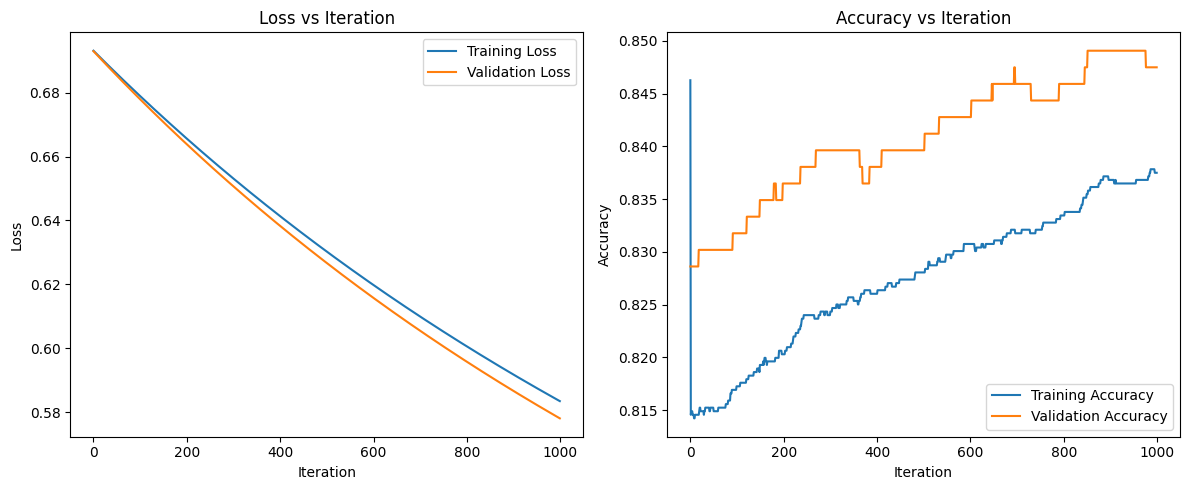

In [25]:
batch_model.plot_metrics()

**Training vs validation loss**

We notice that the training and validation loss decreases steadily over time, which indicates that the model is generalizing well on unseen data. The parallel trend of both losses decreasing indicates that the model is converging appropriately without overfitting, as the validation loss is not increasing after a certain point.

**Training vs validation accuracy**

The training and validation accuracy increases, indicating that the model improves performance over time.

This suggests that the model is converging well over time and is not showing signs of underfitting or overfitting.


#### b. Investigate and compare the performance of the model with different feature scaling methods: Min-max scaling and No scaling. Plot the loss vs. iteration for each method and discuss the impact of feature scaling on model convergence.

**Reference:**

*   [Datacamp](https://www.datacamp.com/tutorial/normalization-in-machine-learning)


Model performance with <b>No Scaling</b>.

In [26]:
# We use the same model from part a

model = BatchGradient_lr(learning_rate=0.001, epochs=1000)
model.fit(X_train, y_train, X_val, y_val)
y_pred = model.predict(X_test)
accuracy = model.compute_accuracy(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8584905660377359


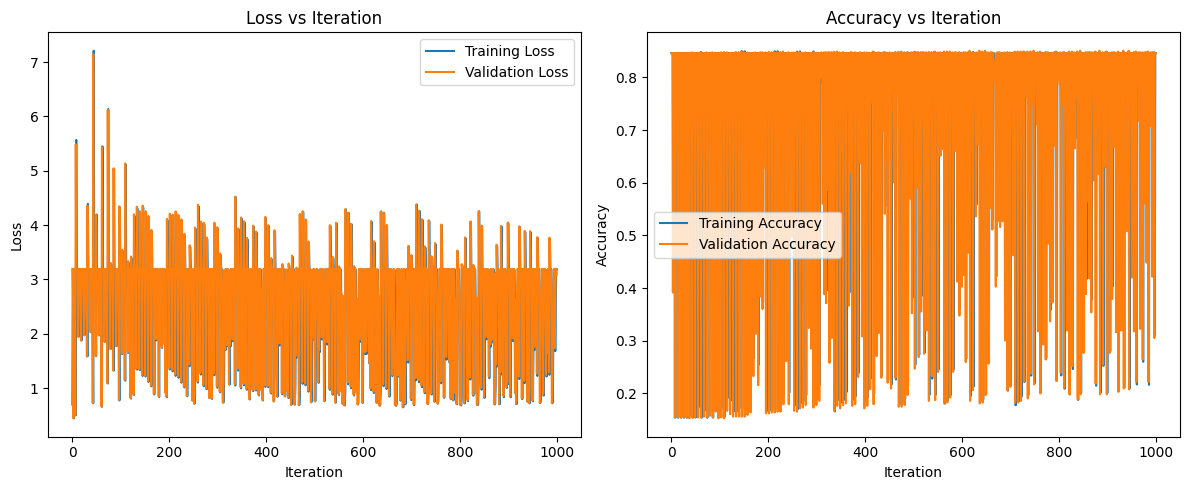

In [27]:
model.plot_metrics()

We notice heavy fluctuations in our loss and accuracy curves when using data with no scaling. This suggests that the model is not converging correctly and is struggling to settle into a consistent learning pattern.

On decreasing the learning rate and number of epochs, the fluctuation decreases and accuracy comes out to be constant.


In [28]:
model = BatchGradient_lr(learning_rate=0.0001, epochs=200)
model.fit(X_train, y_train, X_val, y_val)
y_pred = model.predict(X_test)
accuracy = model.compute_accuracy(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8584905660377359


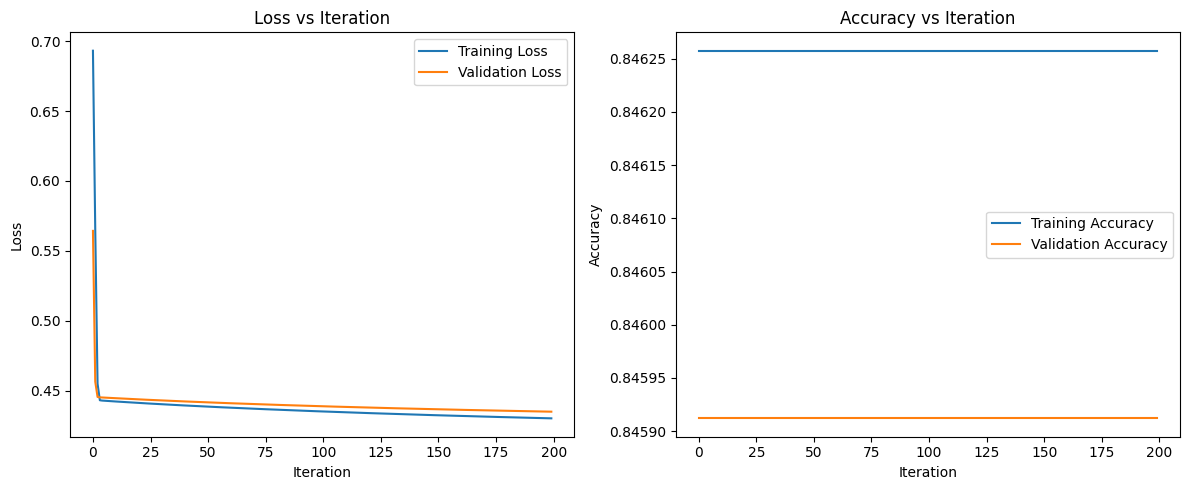

In [29]:
model.plot_metrics()

Model performance with <b>Min-Max Scaling</b>.

In [30]:
# Min-Max Scaling function
def min_max_scaling(X):
    X_min = np.min(X, axis=0)  # Minimum value of each feature
    X_max = np.max(X, axis=0)  # Maximum value of each feature
    return (X - X_min) / (X_max - X_min)

In [31]:
X_train_scaled = min_max_scaling(X_train)
X_val_scaled = min_max_scaling(X_val)
X_test_scaled = min_max_scaling(X_test)

model = BatchGradient_lr(learning_rate=0.001, epochs=1000)
model.fit(X_train_scaled, y_train, X_val_scaled, y_val)
y_pred = model.predict(X_test_scaled)

accuracy = model.compute_accuracy(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8584905660377359


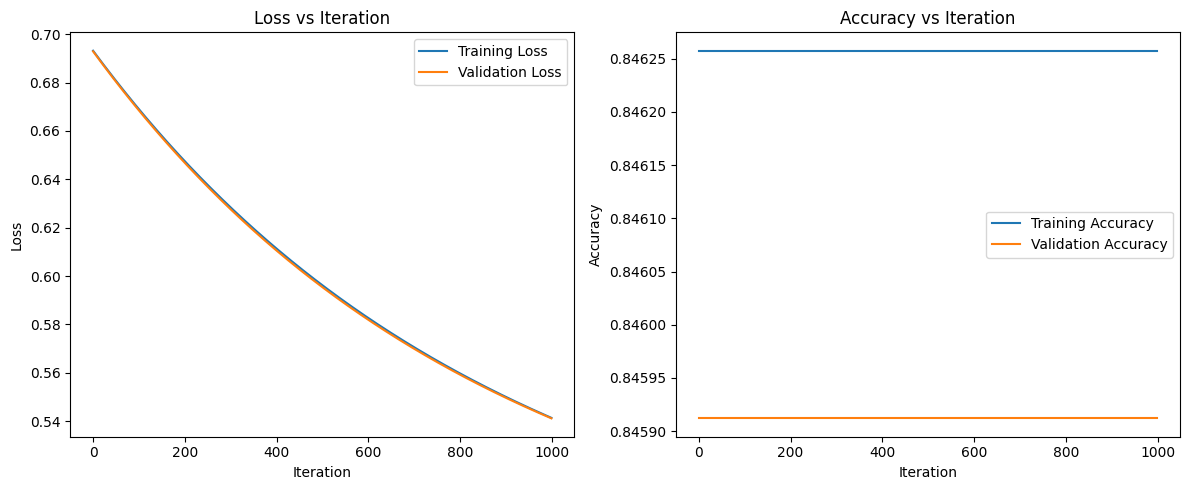

In [32]:
model.plot_metrics()

With min-max scaling, training and validation loss decrease steadily over time, indicating that the model is generalizing well over unseen data. The accuracy of training and validation stays constant over time. Overall, the model converges well and does not show indications of overfitting and underfitting.

Scaling the features has improved the loss and accuracy trend. Feature scaling ensures that all features are within the same range, leading to smoother convergence of the model and preventing any single feature from disproportionately influencing the gradient updates.


#### c. Calculate and present the confusion matrix for the validation set. Report precision, recall, F1 score, and ROC-AUC score for the model based on the validation set. Comment on how these metrics provide insight into the model’s performance.

In [33]:
def get_confusion_matrix(y_true, y_pred):
    confusion_matrix = [[0, 0], [0, 0]]
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            # Correct prediction
            if y_true[i] == 1:
                # True Positive (TP)
                confusion_matrix[1][1] += 1
            else:
                # True Negative (TN)
                confusion_matrix[0][0] += 1
        else:
            # Incorrect prediction
            if y_true[i] == 1:
                # False Negative (FN)
                confusion_matrix[1][0] += 1
            else:
                # False Positive (FP)
                confusion_matrix[0][1] += 1
    return confusion_matrix

In [34]:
def get_confusion_matrix_values(conf_matrix):
    tp = conf_matrix[1][1]
    tn = conf_matrix[0][0]
    fp = conf_matrix[0][1]
    fn = conf_matrix[1][0]
    return tp, tn, fp, fn

**For the normalized validation dataset**

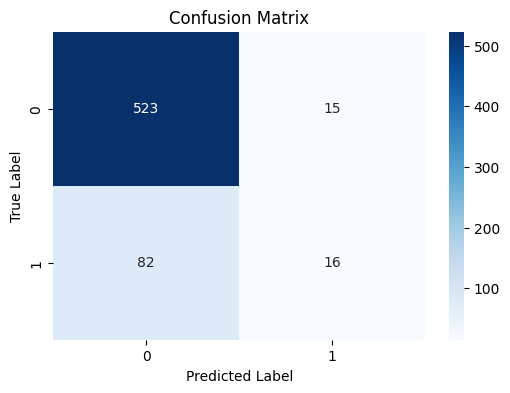

In [35]:
model = BatchGradient_lr(learning_rate=0.001, epochs=1000)
model.fit(X_train_normalized, y_train, X_val_normalized, y_val)

y_val_pred = model.predict(X_val_normalized)
conf_matrix = get_confusion_matrix(y_val.values, y_val_pred)

# Visualizing the Confusion Matrix using Seaborn heatmap
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [36]:
tp, tn, fp, fn = get_confusion_matrix_values(conf_matrix)

In [37]:
def get_precision_score(tp, tn, fp, fn):
    if (tp + fp) == 0:
        return 0.0  # Avoid division by zero
    precision = tp / (tp + fp)
    return precision

In [38]:
def get_recall_score(tp, tn, fp, fn):
    if (tp + fn) == 0:
        return 0.0  # Avoid division by zero
    recall = tp / (tp + fn)
    return recall

In [39]:
def get_f1_score(tp, tn, fp, fn):
    precision = get_precision_score(tp, tn, fp, fn)
    recall = get_recall_score(tp, tn, fp, fn)
    if (precision + recall) == 0:
        return 0.0  # Avoid division by zero
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

In [40]:
def get_evaluation_metrics(tp, tn, fp, fn, y_val, y_val_pred):
    # Precision
    precision = get_precision_score(tp, tn, fp, fn)
    print(f"Precision: {precision}")

    # Recall
    recall = get_recall_score(tp, tn, fp, fn)
    print(f"Recall: {recall}")

    # F1-Score
    f1 = get_f1_score(tp, tn, fp, fn)
    print(f"F1-Score: {f1}")

    # ROC AUC Score (inbuilt from sklearn)
    roc_auc = roc_auc_score(y_val, y_val_pred)
    print(f"ROC AUC Score: {roc_auc}")

In [41]:
get_evaluation_metrics(tp, tn, fp, fn, y_val, y_val_pred)

Precision: 0.5161290322580645
Recall: 0.16326530612244897
F1-Score: 0.24806201550387597
ROC AUC Score: 0.5676921326151279


**No Scaling Validation dataset**

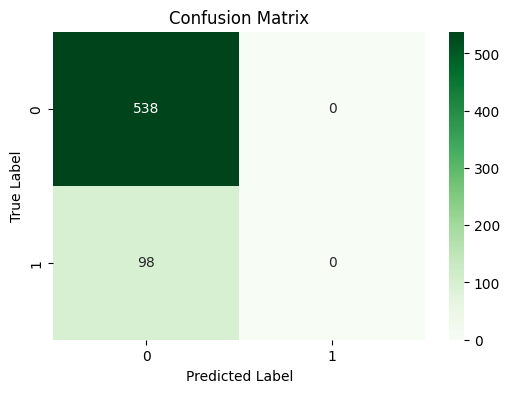

In [42]:
model = BatchGradient_lr(learning_rate=0.001, epochs=1000)
model.fit(X_train, y_train, X_val, y_val)

y_val_pred = model.predict(X_val)
conf_matrix = get_confusion_matrix(y_val.values, y_val_pred)

# Visualizing the Confusion Matrix using Seaborn heatmap
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [43]:
tp, tn, fp, fn = get_confusion_matrix_values(conf_matrix)

In [44]:
get_evaluation_metrics(tp, tn, fp, fn, y_val, y_val_pred)

Precision: 0.0
Recall: 0.0
F1-Score: 0.0
ROC AUC Score: 0.5


**Min Max Scaling validation dataset**

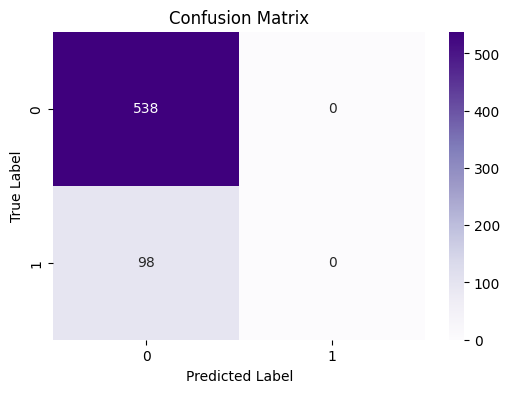

In [45]:
model = BatchGradient_lr(learning_rate=0.001, epochs=1000)
model.fit(X_train_scaled, y_train, X_val_scaled, y_val)

y_val_pred = model.predict(X_val_scaled)
conf_matrix = get_confusion_matrix(y_val.values, y_val_pred)

# Visualizing the Confusion Matrix using Seaborn heatmap
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [46]:
tp, tn, fp, fn = get_confusion_matrix_values(conf_matrix)

In [47]:
get_evaluation_metrics(tp, tn, fp, fn, y_val, y_val_pred)

Precision: 0.0
Recall: 0.0
F1-Score: 0.0
ROC AUC Score: 0.5


- **Precision** provides insights into the reliability of positive predictions out of all positive predictions. High precision indicates higher prediction accuracy for positive values.
- **Recall** provides insights into the actual percentage of positive predictions out of expected positive values.
- **F1 score** provides a balanced metric that considers both precision and recall, especially to balance the trade-off.
- **ROC AUC score** provides an overall picture of how well the model can differentiate between classes across different thresholds.

#### d. Implement and compare the following optimisation algorithms: Stochastic Gradient Descent and Mini-Batch Gradient Descent (with varying batch sizes, atleast 2). Plot and compare the loss vs. iteration and accuracy vs. iteration for each method. Discuss the trade-offs in terms of convergence speed and stability between these methods.

**Stochastic Gradient Descent**

In [48]:
class SGD_lr:
    def __init__(self, learning_rate=0.001, epochs=500):
        self.lr = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    # Sigmoid method
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    # Compute binary cross-entropy loss
    def compute_loss(self, y_true, y_pred):
        epsilon = 1e-9  # to avoid log(0)
        y1 = y_true * np.log(y_pred + epsilon)
        y2 = (1 - y_true) * np.log(1 - y_pred + epsilon)
        return -np.mean(y1 + y2)

    # Compute accuracy
    def compute_accuracy(self, y_true, y_pred):
        y_pred_cls = [1 if i > 0.5 else 0 for i in y_pred]
        accuracy = np.mean(y_pred_cls == y_true)
        return accuracy

    # Forward propagation
    def feed_forward(self, X):
        z = np.dot(X, self.weights) + self.bias
        A = self._sigmoid(z)
        return A

    # Fit the model with training data and validation data
    def fit(self, X_train, y_train, X_val = None, y_val = None):
        n_samples, n_features = X_train.shape

        # Initialize parameters
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Stochastic Gradient Descent
        for _ in range(self.epochs):
            for i in range(n_samples):
                X_i = X_train[i].reshape(1, -1)
                y_i = y_train[i].reshape(1,)

                # Forward pass
                A_train = self.feed_forward(X_i)
                dz = A_train - y_i
                dw = np.dot(X_i.T, dz)
                db = dz

                # Update parameters
                self.weights -= self.lr * dw
                self.bias -= self.lr * db

            if X_val is not None and y_val is not None:
                # Compute training loss and accuracy at each iteration
                A_train = self.feed_forward(X_train)
                self.train_losses.append(self.compute_loss(y_train, A_train))
                self.train_accuracies.append(self.compute_accuracy(y_train, A_train))
                # Validation loss and accuracy
                A_val = self.feed_forward(X_val)
                self.val_losses.append(self.compute_loss(y_val, A_val))
                self.val_accuracies.append(self.compute_accuracy(y_val, A_val))

    # Prediction
    def predict(self, X):
        y_hat = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(y_hat)
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(y_predicted_cls)

    # Plotting the curves
    def plot_metrics(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # Training Loss vs Iteration and Validation Loss vs Iteration
        ax1.plot(self.train_losses, label="Training Loss")
        if self.val_losses:
            ax1.plot(self.val_losses, label="Validation Loss")
        ax1.set_title("Loss vs Iteration")
        ax1.set_xlabel("Iteration")
        ax1.set_ylabel("Loss")
        ax1.legend()

        # Training Accuracy vs Iteration and Validation Accuracy vs Iteration
        ax2.plot(self.train_accuracies, label="Training Accuracy")
        if self.val_accuracies:
            ax2.plot(self.val_accuracies, label="Validation Accuracy")
        ax2.set_title("Accuracy vs Iteration")
        ax2.set_xlabel("Iteration")
        ax2.set_ylabel("Accuracy")
        ax2.legend()
        plt.tight_layout()
        plt.show()

In [49]:
X_train_scaled = min_max_scaling(X_train)
X_val_scaled = min_max_scaling(X_val)
X_test_scaled = min_max_scaling(X_test)

model = SGD_lr(learning_rate=0.001, epochs=500)
model.fit(X_train_scaled.values, y_train.values, X_val_scaled.values, y_val.values)
y_pred = model.predict(X_test_scaled.values)
accuracy = model.compute_accuracy(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8616352201257862


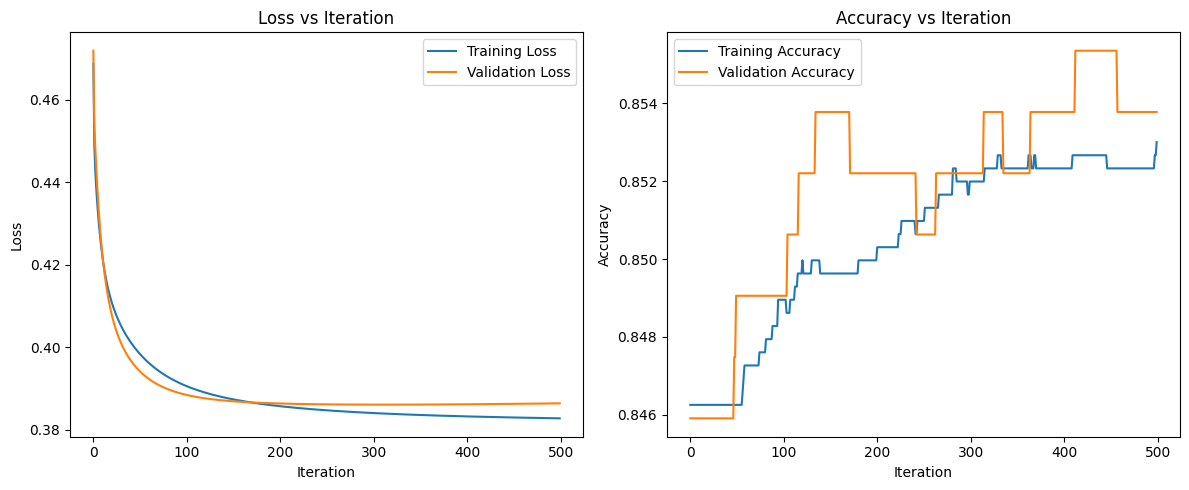

In [50]:
model.plot_metrics()

**Mini-Batch Gradient Descent**

In [51]:
class MiniBatch_lr:
    def __init__(self, learning_rate=0.001, epochs=1000, batch_size=8):
        self.lr = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.weights = None
        self.bias = None
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    # Sigmoid method
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    # Compute binary cross-entropy loss
    def compute_loss(self, y_true, y_pred):
        epsilon = 1e-9  # to avoid log(0)
        y1 = y_true * np.log(y_pred + epsilon)
        y2 = (1 - y_true) * np.log(1 - y_pred + epsilon)
        return -np.mean(y1 + y2)

    # Compute accuracy
    def compute_accuracy(self, y_true, y_pred):
        y_pred_cls = [1 if i > 0.5 else 0 for i in y_pred]
        accuracy = np.mean(y_pred_cls == y_true)
        return accuracy

    # Forward propagation
    def feed_forward(self, X):
        z = np.dot(X, self.weights) + self.bias
        A = self._sigmoid(z)
        return A

    # Fit the model with training data and validation data
    def fit(self, X_train, y_train, X_val = None, y_val = None):
        n_samples, n_features = X_train.shape

        # Initialize weights and bias
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Mini-Batch Gradient Descent
        for _ in range(self.epochs):
            indices = np.random.permutation(n_samples)
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train[indices]

            # Process in mini-batches
            for start in range(0, n_samples, self.batch_size):
                end = min(start + self.batch_size, n_samples)
                X_batch = X_train_shuffled[start:end]
                y_batch = y_train_shuffled[start:end]
                A_batch = self.feed_forward(X_batch)

                dz = A_batch - y_batch
                dw = (1 / len(X_batch)) * np.dot(X_batch.T, dz)
                db = (1 / len(X_batch)) * np.sum(dz)
                self.weights -= self.lr * dw
                self.bias -= self.lr * db

            # Compute training loss and accuracy at each iteration
            if X_val is not None and y_val is not None:
                A_train = self.feed_forward(X_train)
                self.train_losses.append(self.compute_loss(y_train, A_train))
                self.train_accuracies.append(self.compute_accuracy(y_train, A_train))

                # Validation loss and accuracy
                A_val = self.feed_forward(X_val)
                self.val_losses.append(self.compute_loss(y_val, A_val))
                self.val_accuracies.append(self.compute_accuracy(y_val, A_val))

    # Prediction
    def predict(self, X):
        y_hat = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(y_hat)
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]

        return np.array(y_predicted_cls)

    # Plotting the curves
    def plot_metrics(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # Training Loss vs Iteration and Validation Loss vs Iteration
        ax1.plot(self.train_losses, label="Training Loss")
        if self.val_losses:
            ax1.plot(self.val_losses, label="Validation Loss")
        ax1.set_title("Loss vs Iteration")
        ax1.set_xlabel("Iteration")
        ax1.set_ylabel("Loss")
        ax1.legend()

        # Training Accuracy vs Iteration and Validation Accuracy vs Iteration
        ax2.plot(self.train_accuracies, label="Training Accuracy")
        if self.val_accuracies:
            ax2.plot(self.val_accuracies, label="Validation Accuracy")
        ax2.set_title("Accuracy vs Iteration")
        ax2.set_xlabel("Iteration")
        ax2.set_ylabel("Accuracy")
        ax2.legend()
        plt.tight_layout()
        plt.show()

Here, we test our model for default batch size, that is 8.

In [52]:
X_train_scaled = min_max_scaling(X_train)
X_val_scaled = min_max_scaling(X_val)
X_test_scaled = min_max_scaling(X_test)

model = MiniBatch_lr(learning_rate=0.001, epochs=1000, batch_size = 8)
model.fit(X_train_scaled.values, y_train.values, X_val_scaled.values, y_val.values)
y_pred = model.predict(X_test_scaled.values)
accuracy = model.compute_accuracy(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.860062893081761


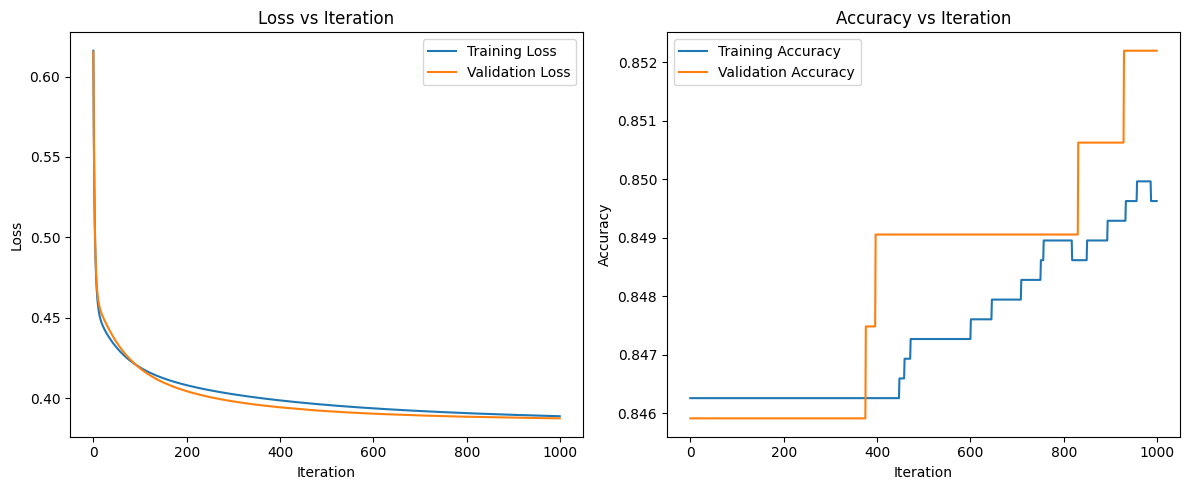

In [53]:
model.plot_metrics()

Now we test it for batch size = 64.

In [54]:
X_train_scaled = min_max_scaling(X_train)
X_val_scaled = min_max_scaling(X_val)
X_test_scaled = min_max_scaling(X_test)

model = MiniBatch_lr(learning_rate=0.001, epochs=1000, batch_size=64)
model.fit(X_train_scaled.values, y_train.values, X_val_scaled.values, y_val.values)
y_pred = model.predict(X_test_scaled.values)
accuracy = model.compute_accuracy(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8584905660377359


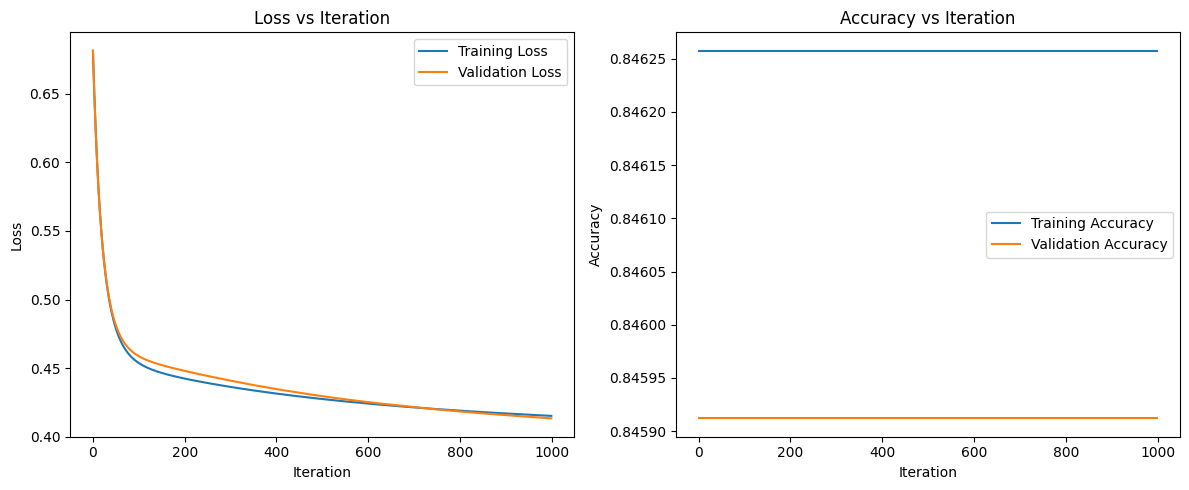

In [55]:
model.plot_metrics()

We notice that the convergence of the Stochastic Gradient Descent model is faster as the training loss and validation loss decrease faster than the Mini Batch but there is more fluctuation in the training and validation accuracy for SGD indicating less stability as compared to the Mini Batch. Hence, we notice that as the convergence speed increases, the stability of training decreases.

Further, in the Mini Batch model, we notice that as we increase the batch size, the convergence slows down, the model training becomes more stable, and accuracy saturates quicker than when the batch size is smaller.


#### e. Implement k-fold cross-validation (with k=5) to assess the robustness of your model. Report the average and standard deviation for accuracy, precision, recall, and F1 score across the folds. Discuss the stability and variance of the model’s performance across different folds.

We implement k-fold cross validation on our SGD model as it is the best performing model in terms of accuracy.

**Reference:**


*   [Medium](https://medium.com/@avijit.bhattacharjee1996/implementing-k-fold-cross-validation-from-scratch-in-python-ae413b41c80d)



In [56]:
def kfold_indices(data, k):
    fold_size = len(data) // k
    indices = np.arange(len(data))
    folds = []
    for i in range(k):
        test_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = np.concatenate([indices[:i * fold_size], indices[(i + 1) * fold_size:]])
        folds.append((train_indices, test_indices))
    return folds

We use our SGD model because it is the best performing model.

In [57]:
k = 5
fold_indices = kfold_indices(X, k)

In [58]:
model = SGD_lr(learning_rate=0.001, epochs=500)
scores = []
recall = []
precision = []
f1_scores = []
fold = 0

for train_indices, test_indices in fold_indices:
    fold += 1
    X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
    X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]
    X_train_scaled = min_max_scaling(X_train)
    X_test_scaled = min_max_scaling(X_test)
    model.fit(X_train_scaled.values, y_train.values)

    y_pred = model.predict(X_test_scaled)

    # Calculate the accuracy score for this fold
    fold_score = model.compute_accuracy(y_test, y_pred)

    conf_matrix = get_confusion_matrix(y_test.values, y_pred)
    tp, tn, fp, fn = get_confusion_matrix_values(conf_matrix)

    # Precision
    _precision = get_precision_score(tp, tn, fp, fn)

    # Recall
    _recall = get_recall_score(tp, tn, fp, fn)

    # F1-Score
    _f1 = get_f1_score(tp, tn, fp, fn)

    scores.append(fold_score)
    precision.append(_precision)
    recall.append(_recall)
    f1_scores.append(_f1)

    print("Fold", fold)
    print("Accuracy:", fold_score)
    print("Precision:", _precision)
    print("Recall:", _recall)
    print("F1-Score:", _f1)
    print()

# Calculate the mean accuracy across all folds
mean_accuracy = np.mean(scores)
mean_precision = np.mean(precision)
mean_recall = np.mean(recall)
mean_f1 = np.mean(f1_scores)

# Calculate the standard deviation of accuracy across all folds
std_accuracy = np.std(scores)
std_precision = np.std(precision)
std_recall = np.std(recall)
std_f1 = np.std(f1_scores)

print("K-Fold Cross-Validation Scores:", scores)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)

print("Mean Precision:", mean_precision)
print("Standard Deviation of Precision:", std_precision)

print("Mean Recall:", mean_recall)
print("Standard Deviation of Recall:", std_recall)

print("Mean F1-Score:", mean_f1)
print("Standard Deviation of F1-Score:", std_f1)

Fold 1
Accuracy: 0.8394332939787486
Precision: 0.6875
Recall: 0.07746478873239436
F1-Score: 0.13924050632911392

Fold 2
Accuracy: 0.8630460448642266
Precision: 0.5
Recall: 0.08620689655172414
F1-Score: 0.14705882352941177

Fold 3
Accuracy: 0.8406139315230224
Precision: 0.43902439024390244
Recall: 0.13846153846153847
F1-Score: 0.2105263157894737

Fold 4
Accuracy: 0.8536009445100354
Precision: 0.6
Recall: 0.11627906976744186
F1-Score: 0.19480519480519481

Fold 5
Accuracy: 0.8406139315230224
Precision: 0.4
Recall: 0.12598425196850394
F1-Score: 0.19161676646706585

K-Fold Cross-Validation Scores: [0.8394332939787486, 0.8630460448642266, 0.8406139315230224, 0.8536009445100354, 0.8406139315230224]
Mean Accuracy: 0.8474616292798112
Standard Deviation of Accuracy: 0.009368044592622119
Mean Precision: 0.5253048780487805
Standard Deviation of Precision: 0.10552022623157101
Mean Recall: 0.10887930909632056
Standard Deviation of Recall: 0.023338184175958496
Mean F1-Score: 0.176649521384052
Standar

We notice that the model's accuracy lies within a narrow range of 83 to 86% with a standard deviation of  0.009 only, indicating low variance in the model's accuracy within different folds.

However, we notice that the standard deviation of Precision is relatively higher than other metrics, indicating that the model's ability to correctly predict positive cases is inconsistent across folds.

F1-Score and Recall have comparable standard deviations, which are higher than the standard deviation of Accuracy.

Hence, in k-fold cross-validation, accuracy is a stable metric, while precision, recall, and f1-score show high variance.


#### f. Implement early stopping in your best Gradient Descent method to avoid overfitting. Define and use appropriate stopping criteria. Experiment with different learning rates and regularization techniques (L1 and L2). Plot and compare the performance with and without early stopping. Analyze the effect of early stopping on overfitting and generalization.

We implement early stopping on our stochastic gradient descent model as it is our best-performing model.

**Criteria Used:**
- We set a patience level. Our default patience level is 5.
- We track our best validation loss. If our validation loss does not improve over epochs equal to patience level, we stop the training of our model as this indicates that our model will not be performing better than this and further training could lead to overfitting.
- We set our weights and bias to the best weights and bias obtained during the best validation loss epoch.


In [59]:
class EarlyStopping_lr:
    def __init__(self, learning_rate=0.001, epochs=500, l1=0.0, l2=0.0):
        self.lr = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.l1 = l1  # L1 regularization strength
        self.l2 = l2  # L2 regularization strength

    # Sigmoid method
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    # Compute cross-entropy loss with regularization
    def compute_loss(self, y_true, y_pred):
        epsilon = 1e-9  # to avoid log(0)
        y1 = y_true * np.log(y_pred + epsilon)
        y2 = (1 - y_true) * np.log(1 - y_pred + epsilon)
        base_loss = -np.mean(y1 + y2)

        # Adding L1 and L2 regularization to the loss
        l1_term = self.l1 * np.sum(np.abs(self.weights))
        l2_term = self.l2 * np.sum(self.weights ** 2)
        reg_loss = base_loss + l1_term + l2_term
        return reg_loss

    # Compute accuracy
    def compute_accuracy(self, y_true, y_pred):
        y_pred_cls = [1 if i > 0.5 else 0 for i in y_pred]
        accuracy = np.mean(y_pred_cls == y_true)
        return accuracy

    # Forward propagation
    def feed_forward(self, X):
        z = np.dot(X, self.weights) + self.bias
        A = self._sigmoid(z)
        return A

    # Fit the model with training data and validation data
    def fit(self, X_train, y_train, X_val=None, y_val=None, patience=5):
        n_samples, n_features = X_train.shape

        # Initialize parameters
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Early stopping variables
        best_val_loss = float('inf')
        best_weights = None
        best_bias = None
        counter = 0

        # Stochastic Gradient Descent with L1 and L2 regularization
        for epoch in range(self.epochs):
            for i in range(n_samples):
                X_i = X_train[i].reshape(1, -1)
                y_i = y_train[i].reshape(1,)

                # Forward pass
                A_train = self.feed_forward(X_i)

                dz = A_train - y_i
                dw = np.dot(X_i.T, dz) + self.l1 * np.sign(self.weights) + 2 * self.l2 * self.weights
                db = dz
                self.weights -= self.lr * dw
                self.bias -= self.lr * db

            A_train = self.feed_forward(X_train)
            self.train_losses.append(self.compute_loss(y_train, A_train))
            self.train_accuracies.append(self.compute_accuracy(y_train, A_train))

            # Validation loss and accuracy
            if X_val is not None and y_val is not None:
                A_val = self.feed_forward(X_val)
                val_loss = self.compute_loss(y_val, A_val)
                val_acc = self.compute_accuracy(y_val, A_val)
                self.val_losses.append(val_loss)
                self.val_accuracies.append(val_acc)

                # Early stopping
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_weights = self.weights.copy()
                    best_bias = self.bias
                    counter = 0  # Reset counter if validation improves
                else:
                    counter += 1  # Increment counter if no improvement

                # Checking if early stopping condition is met
                if counter >= patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break

        # Restoring the best weights if early stopping was triggered
        if best_weights is not None:
            self.weights = best_weights
            self.bias = best_bias

    # Prediction
    def predict(self, X):
        y_hat = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(y_hat)
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(y_predicted_cls)

    # Plotting the curves
    def plot_metrics(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # Training Loss vs Iteration and Validation Loss vs Iteration
        ax1.plot(self.train_losses, label="Training Loss")
        if self.val_losses:
            ax1.plot(self.val_losses, label="Validation Loss")
        ax1.set_title("Loss vs Iteration")
        ax1.set_xlabel("Iteration")
        ax1.set_ylabel("Loss")
        ax1.legend()

        # Training Accuracy vs Iteration and Validation Accuracy vs Iteration
        ax2.plot(self.train_accuracies, label="Training Accuracy")
        if self.val_accuracies:
            ax2.plot(self.val_accuracies, label="Validation Accuracy")
        ax2.set_title("Accuracy vs Iteration")
        ax2.set_xlabel("Iteration")
        ax2.set_ylabel("Accuracy")
        ax2.legend()
        plt.tight_layout()
        plt.show()

In [60]:
X_train_scaled = min_max_scaling(X_train)
X_val_scaled = min_max_scaling(X_val)
X_test_scaled = min_max_scaling(X_test)

In [61]:
# Early stopping with l1 = 0, l2 = 0
model = EarlyStopping_lr(learning_rate=0.001, epochs=500)
model.fit(X_train_scaled.values, y_train.values, X_val_scaled.values, y_val.values)
y_pred = model.predict(X_test_scaled.values)
accuracy = model.compute_accuracy(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Early stopping at epoch 231
Accuracy: 0.846517119244392


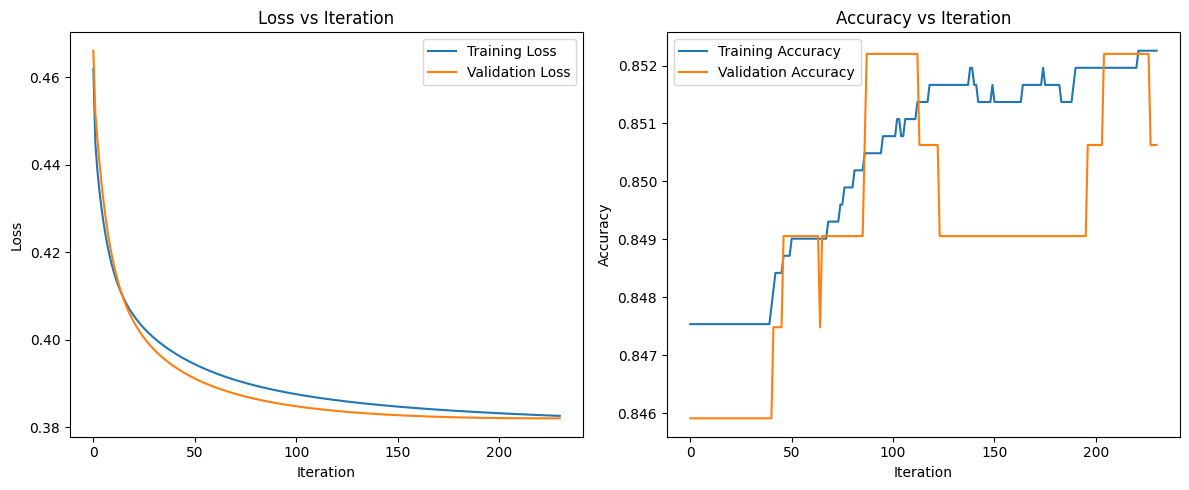

In [62]:
model.plot_metrics()

We experiment with different learning rates and different values for l1 and l2 regularisation.

Early stopping at epoch 154
Accuracy: 0.8524203069657615


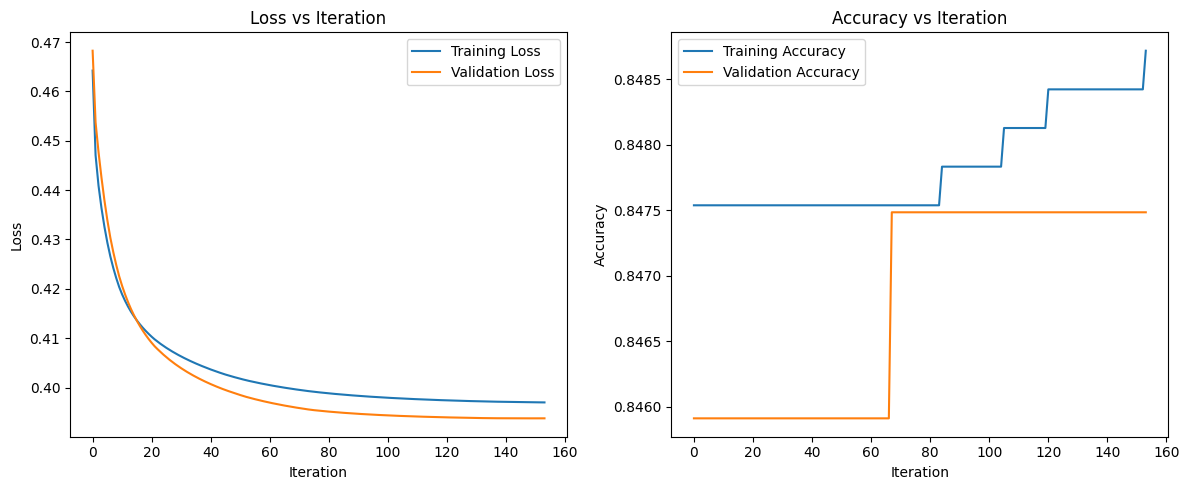

In [63]:
# Early stopping with l1 = 0.001, l2 = 0.001
model = EarlyStopping_lr(learning_rate=0.001, epochs=500, l1 = 0.001, l2 = 0.001)
model.fit(X_train_scaled.values, y_train.values, X_val_scaled.values, y_val.values)
y_pred = model.predict(X_test_scaled.values)
accuracy = model.compute_accuracy(y_test, y_pred)
print(f"Accuracy: {accuracy}")
model.plot_metrics()

Early stopping at epoch 198
Accuracy: 0.8512396694214877


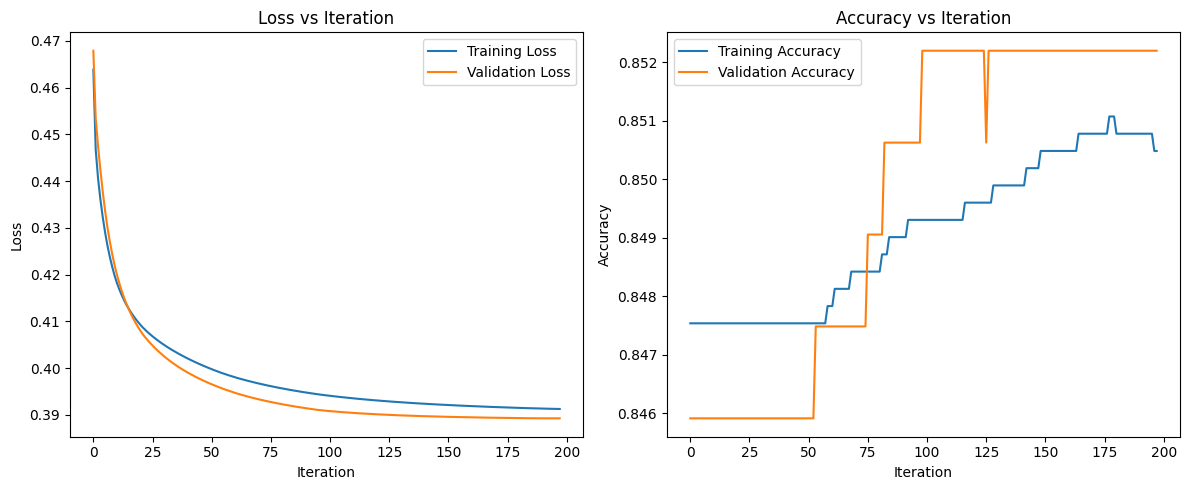

In [64]:
# Early stopping with l1 = 0.001, l2 = 0
model = EarlyStopping_lr(learning_rate=0.001, epochs=500, l1 = 0.001)
model.fit(X_train_scaled.values, y_train.values, X_val_scaled.values, y_val.values)
y_pred = model.predict(X_test_scaled.values)
accuracy = model.compute_accuracy(y_test, y_pred)
print(f"Accuracy: {accuracy}")
model.plot_metrics()

Early stopping at epoch 228
Accuracy: 0.8559622195985832


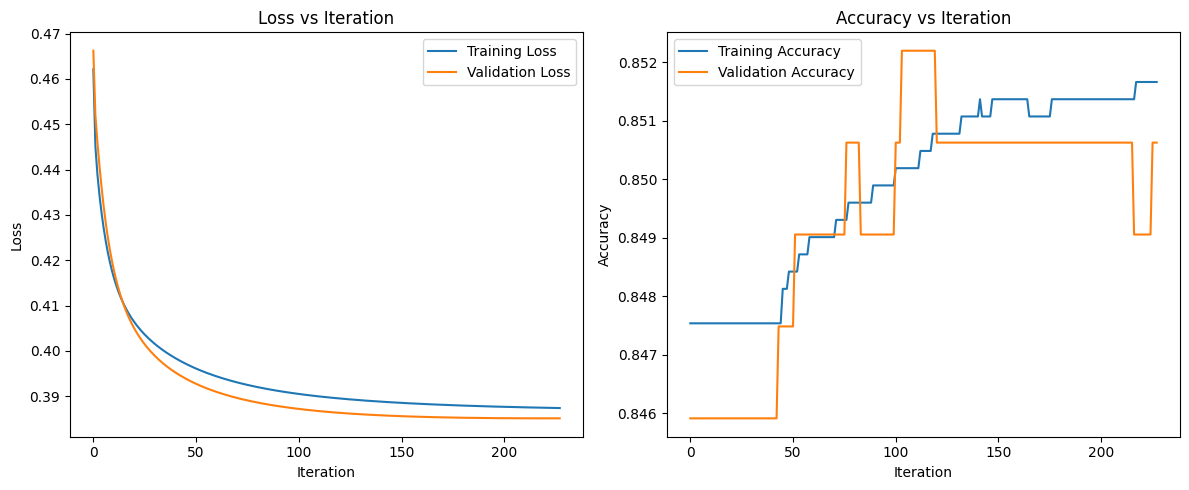

In [65]:
# Early stopping with lr = 0.001, l1 = 0, l2 = 0.0005
model = EarlyStopping_lr(learning_rate=0.001, epochs=500, l2 = 0.0005)
model.fit(X_train_scaled.values, y_train.values, X_val_scaled.values, y_val.values)
y_pred = model.predict(X_test_scaled.values)
accuracy = model.compute_accuracy(y_test, y_pred)
print(f"Accuracy: {accuracy}")
model.plot_metrics()

Now we implement  l1 and l2 regularization on our SGD model without early stopping.

In [66]:
class SGD_l1_l2:
    def __init__(self, learning_rate=0.001, epochs=500, l1=0.0, l2=0.0):
        self.lr = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.l1 = l1  # L1 regularization strength
        self.l2 = l2  # L2 regularization strength

    # Sigmoid method
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    # Compute cross-entropy loss with regularization
    def compute_loss(self, y_true, y_pred):
        epsilon = 1e-9  # to avoid log(0)
        y1 = y_true * np.log(y_pred + epsilon)
        y2 = (1 - y_true) * np.log(1 - y_pred + epsilon)
        base_loss = -np.mean(y1 + y2)

        # Adding L1 and L2 regularization to the loss
        l1_term = self.l1 * np.sum(np.abs(self.weights))
        l2_term = self.l2 * np.sum(self.weights ** 2)
        reg_loss = base_loss + l1_term + l2_term

        return reg_loss

    # Compute accuracy
    def compute_accuracy(self, y_true, y_pred):
        y_pred_cls = [1 if i > 0.5 else 0 for i in y_pred]
        accuracy = np.mean(y_pred_cls == y_true)
        return accuracy

    # Forward propagation
    def feed_forward(self, X):
        z = np.dot(X, self.weights) + self.bias
        A = self._sigmoid(z)
        return A

    # Fit the model with training data and validation data
    def fit(self, X_train, y_train, X_val=None, y_val=None, patience=5):
        n_samples, n_features = X_train.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Stochastic Gradient Descent with L1 and L2 regularization
        for epoch in range(self.epochs):
            for i in range(n_samples):
                X_i = X_train[i].reshape(1, -1)
                y_i = y_train[i].reshape(1,)

                A_train = self.feed_forward(X_i)
                dz = A_train - y_i
                dw = np.dot(X_i.T, dz) + self.l1 * np.sign(self.weights) + 2 * self.l2 * self.weights
                db = dz
                self.weights -= self.lr * dw
                self.bias -= self.lr * db

            # Computing training loss and accuracy at the end of each epoch
            A_train = self.feed_forward(X_train)
            self.train_losses.append(self.compute_loss(y_train, A_train))
            self.train_accuracies.append(self.compute_accuracy(y_train, A_train))

            # Validation loss and accuracy
            if X_val is not None and y_val is not None:
                A_val = self.feed_forward(X_val)
                val_loss = self.compute_loss(y_val, A_val)
                val_acc = self.compute_accuracy(y_val, A_val)
                self.val_losses.append(val_loss)
                self.val_accuracies.append(val_acc)

    # Prediction
    def predict(self, X):
        y_hat = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(y_hat)
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]

        return np.array(y_predicted_cls)

    # Plotting the curves
    def plot_metrics(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # Training Loss vs Iteration and Validation Loss vs Iteration
        ax1.plot(self.train_losses, label="Training Loss")
        if self.val_losses:
            ax1.plot(self.val_losses, label="Validation Loss")
        ax1.set_title("Loss vs Iteration")
        ax1.set_xlabel("Iteration")
        ax1.set_ylabel("Loss")
        ax1.legend()

        # Training Accuracy vs Iteration and Validation Accuracy vs Iteration
        ax2.plot(self.train_accuracies, label="Training Accuracy")
        if self.val_accuracies:
            ax2.plot(self.val_accuracies, label="Validation Accuracy")
        ax2.set_title("Accuracy vs Iteration")
        ax2.set_xlabel("Iteration")
        ax2.set_ylabel("Accuracy")
        ax2.legend()
        plt.tight_layout()
        plt.show()

In [67]:
X_train_scaled = min_max_scaling(X_train)
X_val_scaled = min_max_scaling(X_val)
X_test_scaled = min_max_scaling(X_test)

Accuracy: 0.8500590318772137


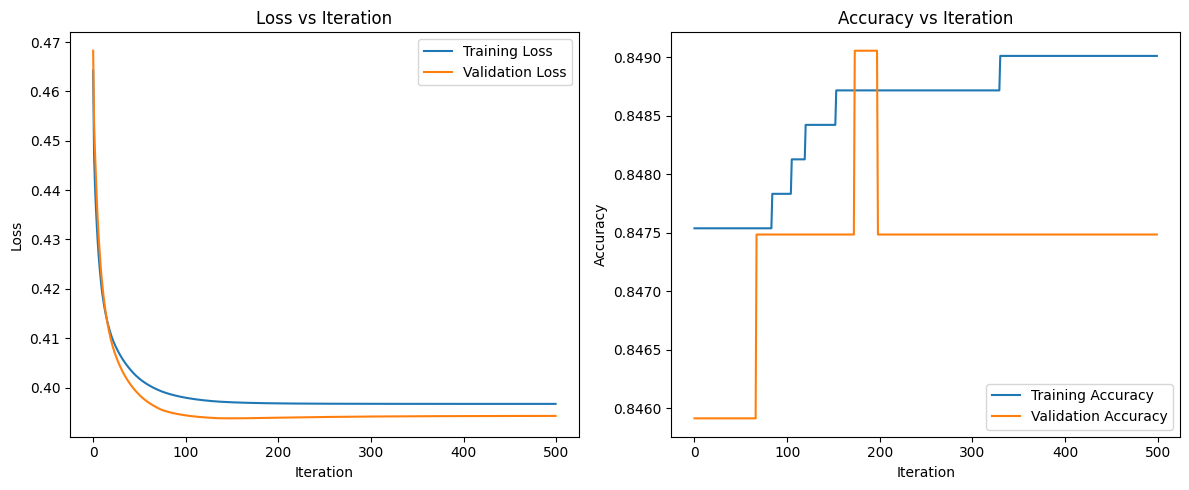

In [68]:
# SGD with l1 = 0.001, l2 = 0.001
model = SGD_l1_l2(learning_rate=0.001, epochs=500, l1 = 0.001, l2 = 0.001)
model.fit(X_train_scaled.values, y_train.values, X_val_scaled.values, y_val.values)
y_pred = model.predict(X_test_scaled.values)
accuracy = model.compute_accuracy(y_test, y_pred)
print(f"Accuracy: {accuracy}")
model.plot_metrics()

Accuracy: 0.8512396694214877


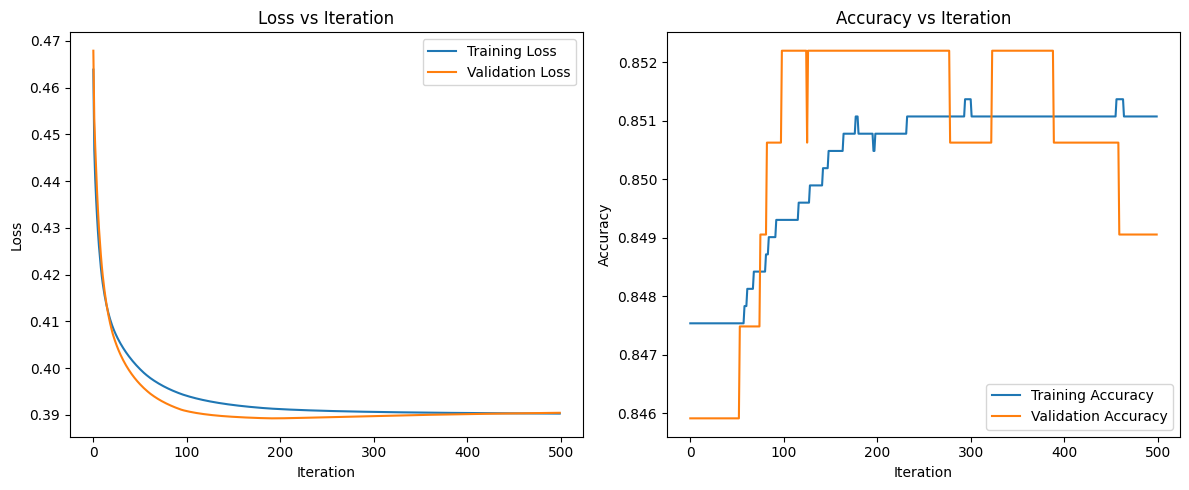

In [69]:
# l1 = 0.001, l2 = 0
model = SGD_l1_l2(learning_rate=0.001, epochs=500, l1 = 0.001)
model.fit(X_train_scaled.values, y_train.values, X_val_scaled.values, y_val.values)
y_pred = model.predict(X_test_scaled.values)
accuracy = model.compute_accuracy(y_test, y_pred)
print(f"Accuracy: {accuracy}")
model.plot_metrics()

Accuracy: 0.8488783943329398


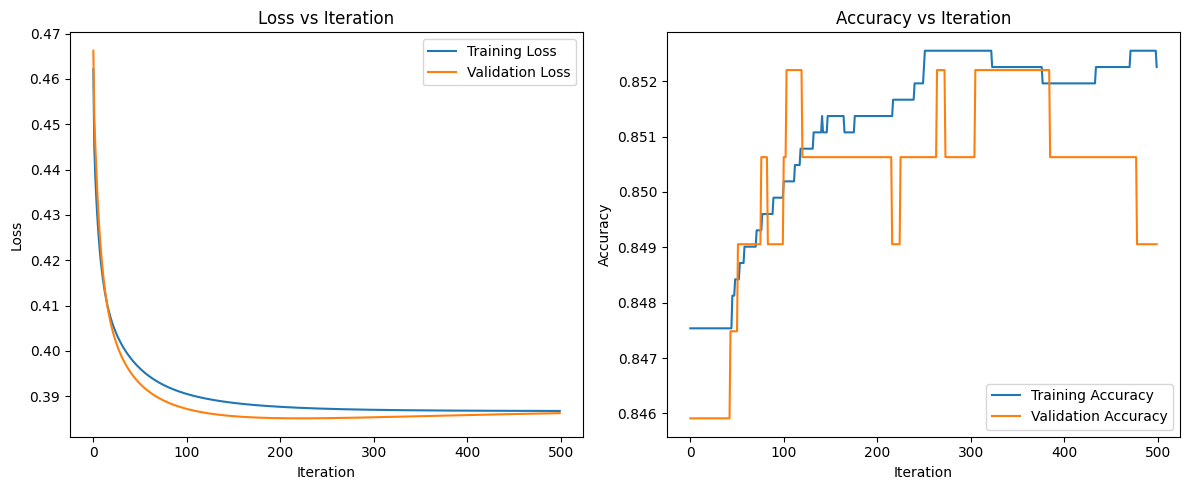

In [70]:
# lr = 0.001, l1 = 0, l2 = 0.0005
model = SGD_l1_l2(learning_rate=0.001, epochs=500, l2 = 0.0005)
model.fit(X_train_scaled.values, y_train.values, X_val_scaled.values, y_val.values)
y_pred = model.predict(X_test_scaled.values)
accuracy = model.compute_accuracy(y_test, y_pred)
print(f"Accuracy: {accuracy}")
model.plot_metrics()

When the model starts to overfit, that is, the validation loss does not seem to be getting better, early stopping causes the model to stop the training process, hence preventing the model from overfitting. Therefore, this model now performs better on unseen data and generalizes better. While early stopping prevents overfitting, it also ensures that the model is trained sufficiently to avoid underfitting.